C:\Users\benwi\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


SystemExit: 0

C:\Users\benwi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2971: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


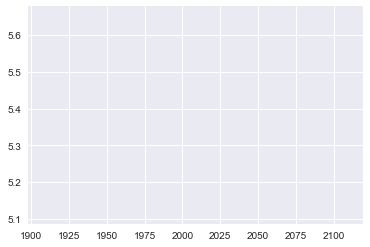

In [2]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
sns.set()
 
from PyQt5.QtWidgets import QApplication, QMainWindow, QMenu, QVBoxLayout, QSizePolicy, QMessageBox, QWidget, QPushButton, QComboBox, QLabel
from PyQt5.QtGui import QIcon

from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
 
import random
 
class App(QMainWindow):
 
    def __init__(self):
        super().__init__()
        self.left = 100
        self.top = 100
        self.title = 'GUI Window for showing water contaminant levels'
        self.width = 1050
        self.height = 430
        
        self.state_fips = 6
        self.water_data = pd.read_csv('water_usage.csv')
        states = self.water_data[['state']].drop_duplicates().values.tolist()
        self.state_list = []
        for i in range(len(states)-1):
            self.state_list.append(states[i][0])
            
        self.initUI()
 
    def initUI(self):
        self.setWindowTitle(self.title)
        self.setGeometry(self.left, self.top, self.width, self.height)
        self.countyData = []
 
        self.m = PlotCanvas(self, width=7, height=4)
        self.m.move(330,10)
 
        self.state = QComboBox(self)
        self.state.addItems(self.state_list)
        self.statelabel = QLabel("State code", self)
        
        self.county = QComboBox(self)
        self.county.addItems(self.countyData)
        self.countylabel = QLabel("County", self)
        
        self.contaminant = QComboBox(self)
        self.contaminant.addItems(['Uranium', 'Arsenic', 'DEHP', 'Nitrates', 'Halo-Acetic acid', 'Trihalomethane'])
        self.contaminantlabel = QLabel("Contaminant", self)
        
        self.plotButton = QPushButton('Generate plot', self)
        self.plotButton.resize(104, 33)
        
        self.state.move(200,10)
        self.statelabel.move(10,10)
        self.county.move(200,60)
        self.countylabel.move(10,60)
        self.contaminant.move(200,110)
        self.contaminantlabel.move(10,110)
        self.plotButton.move(200,166)
        
        # If differents state selected, update possible counties
        self.state.currentIndexChanged.connect(self.get_counties)
        
        # Define state, county and contaminant informatino for plot
        self.m.state_fips = self.state_fips
        self.m.county = str(self.county.currentText())
        self.m.contaminant = str(self.contaminant.currentText())
        self.plotButton.clicked.connect(self.m.plot)
        
        self.county.setVisible(True)
        self.state.setVisible(True)
        
        self.setWindowTitle("Water Quality Assessment")
 
        self.show()
        
    def get_counties(self):
        self.county.clear()       # delete all items from comboBox
        chemical_data = pd.read_csv('chemicals.csv')
        water_data = pd.read_csv('water_usage.csv')
        
        state_code = str(self.state.currentText())

        state_specific = water_data.loc[water_data['state'] == state_code]
        state_fips = state_specific['state_fips'].drop_duplicates().tolist()
        self.state_fips = state_fips[0]

        county_df = chemical_data.loc[chemical_data['state_fips'] == self.state_fips]
        counties = county_df[['county']].drop_duplicates().values.tolist()

        county_list = []
        for i in range(len(counties)-1):
            county_list.append(counties[i][0])

        self.county.addItems(county_list)
        self.county.update()
        
class PlotCanvas(FigureCanvas):
 
    def __init__(self, parent=None, width=5, height=4, dpi=100):
        fig = Figure(figsize=(width, height), dpi=dpi)
        #self.axes = fig.add_subplot(111)
 
        FigureCanvas.__init__(self, fig)
        self.setParent(parent)
 
        FigureCanvas.setSizePolicy(self,
                QSizePolicy.Expanding,
                QSizePolicy.Expanding)
        FigureCanvas.updateGeometry(self) 
 
    def plot(self):
        chemical_data = pd.read_csv('chemicals.csv')
        state_fips = self.state_fips; county_name = self.county; species_name = self.contaminant
                                                    
        """Plot the contamination levels by year for all water supplies in given county for given species."""
        
        #creating structure for maximum safe amount of each species
        max_allowed={"Uranium":30, "Arsenic":10, "DEHP":6000,"Nitrates":10,"Halo-Acetic Acid":60,"Trihalomethane":80}
        threshold=max_allowed[species_name]

        #reduce to county-level only data
        county_data=chemical_data[["chemical_species","value","county","year","unit_measurement","cws_name", "state_fips"]]

        #pick out appropriate county and species
        dt_spec=county_data.loc[county_data["chemical_species"]==species_name]
        dt_county=dt_spec.loc[dt_spec["state_fips"]== state_fips]
        dt_county=dt_county.loc[dt_county["county"] == county_name]

        #creating dataframe for maximum levels
        dt_max=pd.Series(threshold,index=[2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2018,2019,2020,2022,2023,2024,2025])
        dt_max.index.name = 'Year'
        dt_max=dt_max.reset_index(name='Maximum')
        dtminyear=min(dt_spec["year"])

        #plotting contaminant levels
        self.ax = self.figure.add_subplot(111)
        xlim = [dtminyear,2018]
        self.ax.set_xlim(xlim)
        sns.regplot(x='year', y='value',data=dt_spec,ax=self.ax)
        self.ax.plot(dt_max.Year, dt_max.Maximum, linewidth=3,color='r')
        self.ax.set_yscale('log')
        self.ax.set_xticks(np.arange(2000,2017,2))
        self.ax.set_title('{:} data for county {:}'.format(species_name, county_name))
        self.draw()
        
        self.ax.cla()
        
if __name__ == '__main__':
    app = QApplication(sys.argv)
    DatathonGUI = App()
    sys.exit(app.exec_())

In [1]:
water_data = pd.read_csv('water_usage.csv')
states = water_data[['state']].drop_duplicates().values.tolist()

state_list = []
for i in range(len(states)-1):
    state_list.append(states[i][0])
    
def get_counties(state_code):
    chemical_data = pd.read_csv('chemicals.csv')
    water_data = pd.read_csv('water_usage.csv')
    
    state_specific = water_data.loc[water_data['state'] == state_code]
    state_fips = state_specific['state_fips'].drop_duplicates().tolist()
    
    county_df = chemical_data.loc[chemical_data['state_fips'] == state_fips[0]]
    counties = county_df[['county']].drop_duplicates().values.tolist()
    
    county_list = []
    for i in range(len(counties)-1):
        county_list.append(counties[i][0])
    
    return county_list

NameError: name 'pd' is not defined

In [6]:
chemical_data = pd.read_csv('chemicals.csv')
states = chemical_data[['state_fips']].drop_duplicates().values.tolist()
print(len(states))

27


In [5]:
get_counties('CA')

['Alameda',
 'Alpine',
 'Amador',
 'Butte',
 'Calaveras',
 'Colusa',
 'Contra Costa',
 'Del Norte',
 'El Dorado',
 'Fresno',
 'Glenn',
 'Humboldt',
 'Imperial',
 'Inyo',
 'Kern',
 'Kings',
 'Lake',
 'Lassen',
 'Los Angeles',
 'Madera',
 'Marin',
 'Mariposa',
 'Mendocino',
 'Merced',
 'Modoc',
 'Mono',
 'Monterey',
 'Napa',
 'Nevada',
 'Orange',
 'Placer',
 'Plumas',
 'Riverside',
 'Sacramento',
 'San Benito',
 'San Bernardino',
 'San Diego',
 'San Francisco',
 'San Joaquin',
 'San Luis Obispo',
 'San Mateo',
 'Santa Barbara',
 'Santa Clara',
 'Santa Cruz',
 'Shasta',
 'Sierra',
 'Siskiyou',
 'Solano',
 'Sonoma',
 'Stanislaus',
 'Sutter',
 'Tehama',
 'Trinity',
 'Tulare',
 'Tuolumne',
 'Ventura',
 'Yolo']